In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox  # version '0.16.0' or greater
import mobair as mb

In [3]:
import pickle

# importing a dictionary of type: {(city, start_date, end_date, distribution_type) : "file_name"}
# carrying the name of the files with the data
PATH_TO_INPUT_FILES = './data/private/'
infile = open(PATH_TO_INPUT_FILES + 'input_file_names.pkl','rb')
dict_file_names = pickle.load(infile)

In [5]:
# the distribution_type can be:
set(key[3] for key in dict_file_names.keys())

{'emissions_commuting_traj',
 'emissions_commuting_traj_aggregated_by_road',
 'emissions_commuting_traj_aggregated_by_vehicle',
 'emissions_commuting_traj_relaxed_work_location',
 'emissions_commuting_traj_relaxed_work_location_aggregated_by_road',
 'emissions_commuting_traj_relaxed_work_location_aggregated_by_vehicle',
 'emissions_commuting_traj_subsampled',
 'emissions_commuting_traj_subsampled_aggregated_by_road',
 'emissions_commuting_traj_subsampled_aggregated_by_vehicle',
 'emissions_traj',
 'emissions_traj_aggregated_by_road',
 'emissions_traj_aggregated_by_vehicle',
 'emissions_traj_subsampled',
 'emissions_traj_subsampled_aggregated_by_road',
 'emissions_traj_subsampled_aggregated_by_vehicle',
 'original_traj',
 'original_traj_subsampled'}

# Lorenz curves and Gini coefficients across seasons
Code for obtaining the __Supplementary Figures 3-5__.

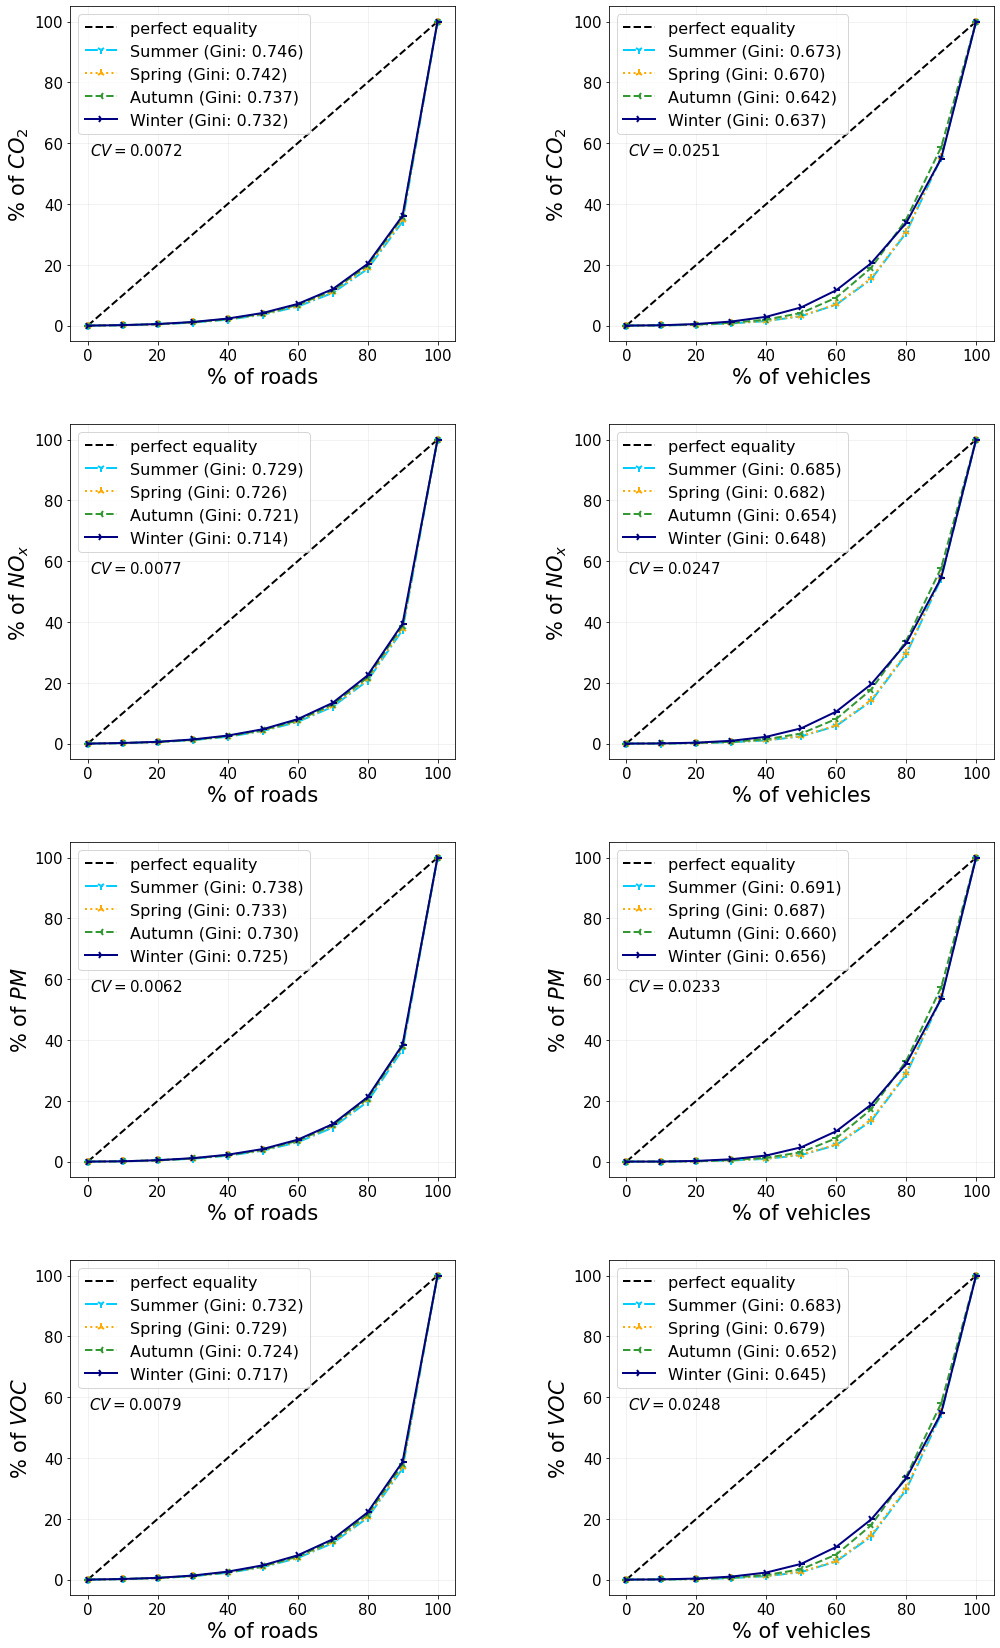

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import variation

# choose on of "Greater London", "Rome", "Florence"
REGION = 'Greater London'


#####
list__tuple_dist_pollutant = [
    ('roads', 'CO_2'), ('vehicles', 'CO_2'),
    ('roads', 'NO_x'), ('vehicles', 'NO_x'),
    ('roads', 'PM'), ('vehicles', 'PM'),
    ('roads', 'VOC'), ('vehicles', 'VOC'),
]
map__season__plot_pars = {
    'summer' : {
        'linestyle' : '-.',
        'marker' : '1',
        'color' : '#00ccff'
    },
    'spring' : {
        'linestyle' : ':',
        'marker' : '2',
        'color' : '#ffaa00'
    },
    'autumn' : {
        'linestyle' : '--',
        'marker' : '3',
        'color' : '#339933'
    },
    'winter' : {
        'linestyle' : '-',
        'marker' : '4',
        'color' : 'navy'
    }
}
map__season__start_end_date = {
    'spring' : ('2017-03-01', '2017-05-31'),
    'summer' : ('2017-06-01', '2017-08-31'),
    'autumn' : ('2017-09-01', '2017-11-22'),
    'winter' : ('2017-12-01', '2017-02-28')
}
######

####
# defining the function used for computing the curve and the Gini coefficient
def Lorenz(v, bins):
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return yvals, gini_val
####


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 23))

for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    # plotting line of perfect equality
    bins = np.linspace(0., 100., 11)
    ax.plot(bins, bins, '--', label="perfect equality", color='black', linewidth=2)
    
    map__season__gini = {}
    map__season__result = {}
    for c_season in ['winter', 'spring', 'summer', 'autumn',]:
        # loading df
        region_name = REGION.lower().replace(" ", "_")
        start_date = map__season__start_end_date[c_season][0]
        end_date = map__season__start_end_date[c_season][1]
        trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
        NAME_OF_INPUT_FILE = dict_file_names[(region_name, 
                                              start_date, end_date, 
                                              trajectory_type)]
        df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
        
        # tacking the column with the current pollutant
        list_cumulate_emissions = list(df[c_pollutant])
        
        # plotting Lorenz curve for current season
        result, gini_val = Lorenz(np.array(list_cumulate_emissions), bins)
        map__season__gini[c_season] = gini_val
        map__season__result[c_season] = result
    
    map__season__gini__sorted = {season:gini for season,gini in sorted(map__season__gini.items(), key=lambda item: item[1], reverse=True)}
    for c_season,c_gini in map__season__gini__sorted.items():
        ax.plot(bins, map__season__result[c_season], label='%s (Gini: %.3f)' %(c_season.capitalize(), c_gini), 
               color=map__season__plot_pars[c_season]['color'],
                linestyle=map__season__plot_pars[c_season]['linestyle'],
                linewidth=2, alpha=1,
                marker=map__season__plot_pars[c_season]['marker'],
                markersize=8, markeredgewidth=2,
                markerfacecolor=map__season__plot_pars[c_season]['color'], markeredgecolor=map__season__plot_pars[c_season]['color'])
    # coefficient of variation
    cv = variation(list(map__season__gini__sorted.values()))
    ax.text(0.17, 0.57, r'$CV = %.4f$' %cv, fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel(r'%% of %s' %dist_type, fontsize=21)
    ax.set_ylabel(r'%% of $%s$' %c_pollutant, fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=16)
    #handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    #ax.legend(handles, labels)

#plt.subplots_adjust(wspace = 5, hspace = 3)
#plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.25)
plt.show()

# Emissions' distributions across seasons
Code for obtaining the __Supplementary Figures 6-8__.

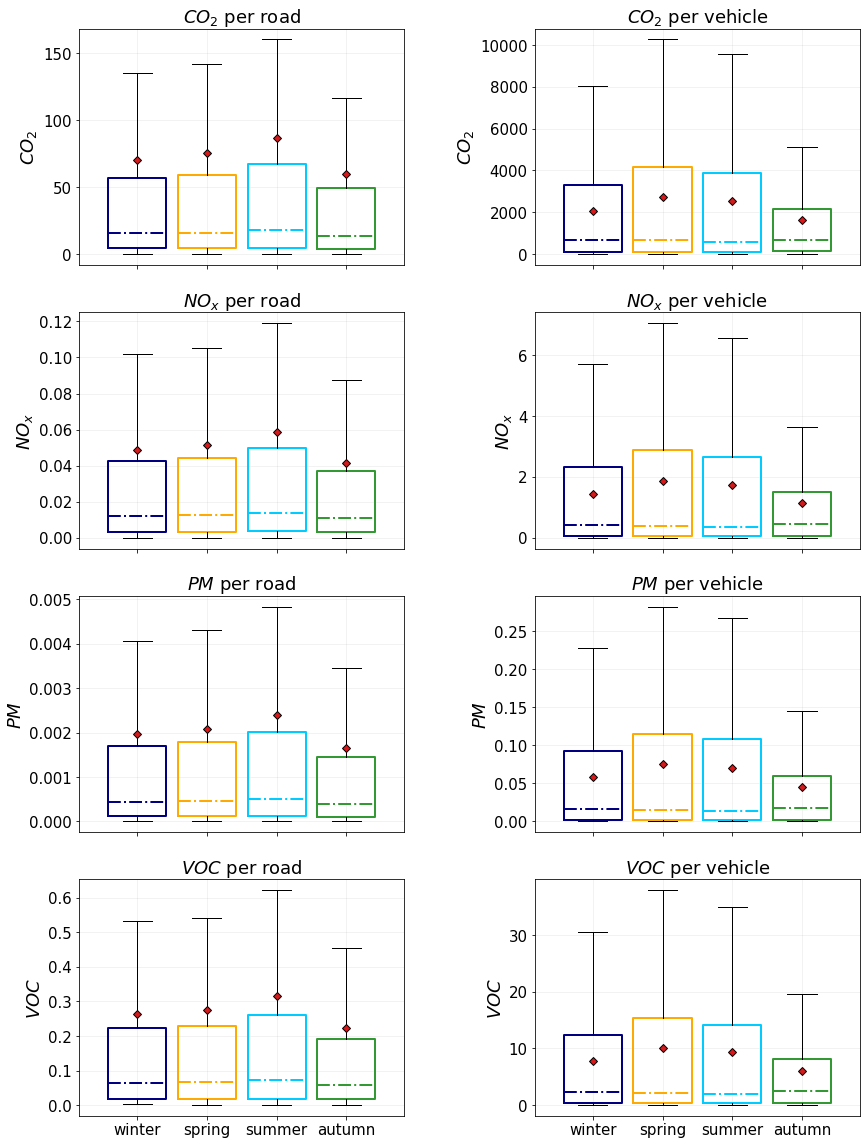

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

REGION = 'Greater London'

show_outliers=False
show_means=True

######
list__tuple_dist_pollutant = [
    ('roads', 'CO_2'), ('vehicles', 'CO_2'),
    ('roads', 'NO_x'), ('vehicles', 'NO_x'),
    ('roads', 'PM'), ('vehicles', 'PM'),
    ('roads', 'VOC'), ('vehicles', 'VOC'),
]
map__season__plot_pars = {
    'summer' : {
        'linestyle' : '-.',
        'marker' : '1',
        'color' : '#00ccff'
    },
    'spring' : {
        'linestyle' : ':',
        'marker' : '2',
        'color' : '#ffaa00'
    },
    'autumn' : {
        'linestyle' : '--',
        'marker' : '3',
        'color' : '#339933'
    },
    'winter' : {
        'linestyle' : '-',
        'marker' : '4',
        'color' : 'navy'
    }
}
map__season__start_end_date = {
    'spring' : ('2017-03-01', '2017-05-31'),
    'summer' : ('2017-06-01', '2017-08-31'),
    'autumn' : ('2017-09-01', '2017-11-22'),
    'winter' : ('2017-12-01', '2017-02-28')
}
######

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 20), sharex=True)

for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    map__season__distribution = {}
    for c_season in ['winter', 'spring', 'summer', 'autumn',]:
        # loading df
        region_name = REGION.lower().replace(" ", "_")
        start_date = map__season__start_end_date[c_season][0]
        end_date = map__season__start_end_date[c_season][1]
        trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
        NAME_OF_INPUT_FILE = dict_file_names[(region_name, 
                                              start_date, end_date, 
                                              trajectory_type)]
        df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)

        # tacking the column with the current pollutant
        list_cumulate_emissions = list(df[c_pollutant])

        map__season__distribution[c_season] = list_cumulate_emissions
    
    data = [distrib for x_key,distrib in sorted(map__season__distribution.items())]
    list_of_x_keys = map__season__distribution.keys()

    #
    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
        plt.setp(bp['fliers'], markeredgecolor=color)
        return

    epsilon_widths = 0.1
    selected_width = 0.5
    pos_a = []
    c_position = 0
    for index in range(len(list_of_x_keys)):
        pos_a.append(c_position)
        c_position += selected_width + epsilon_widths

    bpl = ax.boxplot(data, positions=pos_a, widths=selected_width,
                    showfliers=show_outliers,
                    showmeans=show_means,
                    flierprops=dict(marker='o', markersize=3 * selected_width, markeredgewidth=0.99),
                    medianprops = dict(linestyle='-.', linewidth=2),
                    meanprops = dict(marker='D', markersize=5, markeredgecolor='black', markerfacecolor='#D7191C', markeredgewidth=0.99))
    #set_box_color(bpl, '#D7191C')
    for b, c_season in zip(bpl['boxes'],['winter', 'spring', 'summer', 'autumn',]):
        b.set(color=map__season__plot_pars[c_season]['color'], linewidth=2)
    #for w, c_season in zip(bpl['whiskers'],['winter', 'spring', 'summer', 'autumn',]):
    #    w.set(color=map__season__plot_pars[c_season]['color'])
    #for c, c_season in zip(bpl['caps'],['winter', 'spring', 'summer', 'autumn',]):
    #    c.set(color=map__season__plot_pars[c_season]['color'])
    for m, c_season in zip(bpl['medians'],['winter', 'spring', 'summer', 'autumn',]):
        m.set(color=map__season__plot_pars[c_season]['color'])
    #for f, c_season in zip(bpl['fliers'],['winter', 'spring', 'summer', 'autumn',]):
    #    f.set(color=map__season__plot_pars[c_season]['color'])
    
    ax.set_xticks(pos_a)  ##########
    ax.set_xticklabels(list_of_x_keys)
    
    #ax.set_ylim(0.65, 0.90)
    #ax.set_ylim(0.50, 0.90)
    #ax.set_xlabel("sample size (% of data)", size='large', weight='bold' , fontsize=16)
    ax.set_ylabel('$%s$' %c_pollutant, size='large', weight='bold' , fontsize=18)
    
    #ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.set_title(r'$%s$ per %s, %s' %(c_pollutant, dist_type, city_name.replace('_',' ').capitalize()), fontsize=16)
    ax.set_title(r'$%s$ per %s' %(c_pollutant, dist_type[:-1]), fontsize=18)
    ax.grid(alpha=0.2)

#fig.supxlabel("sample size (% of data)", size='large', weight='bold' , fontsize=16)
#fig.supylabel("Emissions", size='large', weight='bold' , fontsize=16, ha='left')
plt.subplots_adjust(wspace = 0.4, hspace = 0.2)
plt.show()

# Emissions' distributions in one month
Code for obtaining the __Supplementary Figures 10-11__.

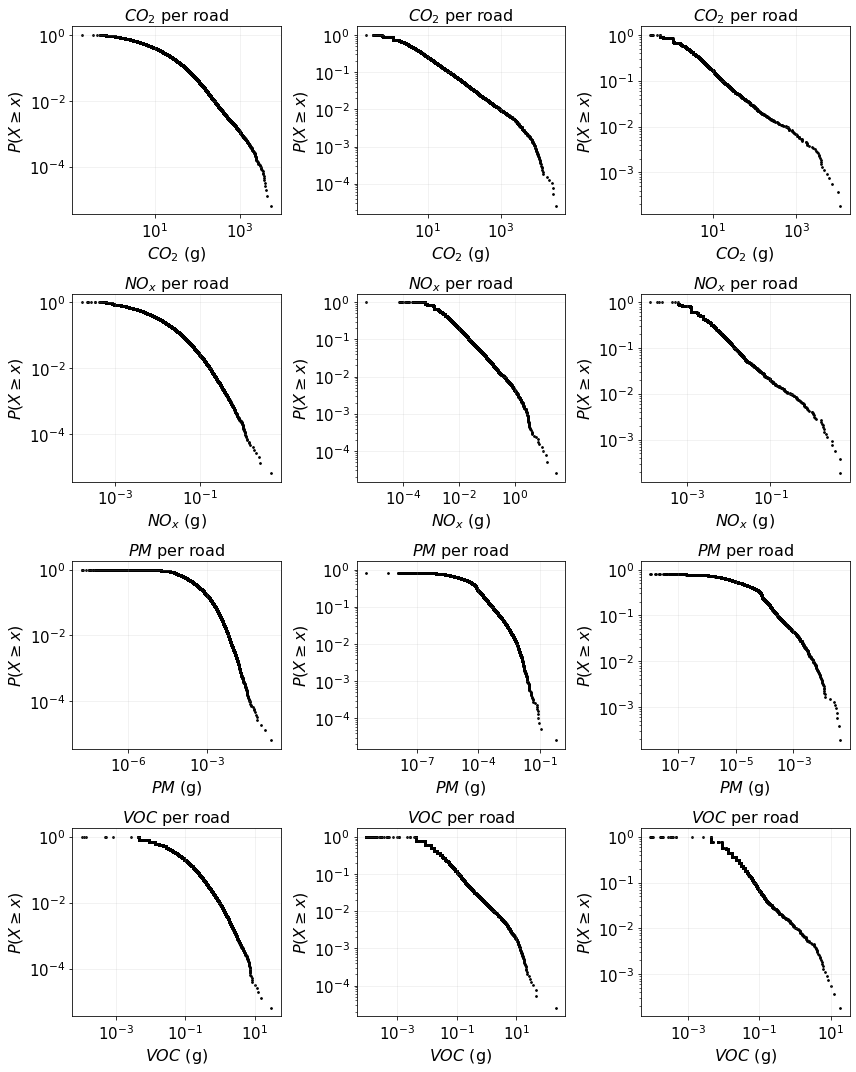

In [12]:
import matplotlib.pyplot as plt
from powerlaw import ccdf
import pandas as pd

start_date = '2017-01-01'
end_date = '2017-01-31'

# choose the type of distribution of emissions: per vehicle / per road 
dist_type = 'roads'  # one of {'vehicles', 'roads'}

list__tuple_city_pollutant = [
    ('Greater London', 'CO_2'), ('Rome', 'CO_2'), ('Florence', 'CO_2'), 
    ('Greater London', 'NO_x'), ('Rome', 'NO_x'), ('Florence', 'NO_x'), 
    ('Greater London', 'PM'), ('Rome', 'PM'), ('Florence', 'PM'), 
    ('Greater London', 'VOC'), ('Rome', 'VOC'), ('Florence', 'VOC'), 
]


fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))

for ax, (c_city, c_pollutant) in zip(axs.flat, list__tuple_city_pollutant):
    
    # loading df
    #df = pd.read_csv('./data/cumulate_emissions_per_%s__%s.csv' %(dist_type, city_name.lower().replace(' ', '_')), index_col=0)
    city_name = c_city.lower().replace(" ", "_")
    trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
    NAME_OF_INPUT_FILE = dict_file_names[(city_name, 
                                          start_date, end_date, 
                                          trajectory_type)]
    df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
    
    # tacking the column with the current pollutant
    list_cumulate_emissions = list(df[c_pollutant])
    
    # using powerlaw package to compute the CCDF of the current distribution
    x, y = ccdf(list_cumulate_emissions, linear_bins=False)
    
    # plotting
    ax.scatter(x, y, color='black', s=3, label='data')
    ax.set_xlabel(r'$%s$ (g)' %c_pollutant, fontsize=16)
    ax.set_ylabel(r'$P(X \geq x)$', fontsize=16)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$%s$ per %s' %(c_pollutant, dist_type[:-1]), fontsize=16)
    ax.grid(alpha=0.2)

plt.tight_layout()
#plt.savefig('Figure_ccdf_%s.png' %dist_type, dpi=300)
plt.show()

# Lorenz curves for one month across cities
Code for obtaining the __Supplementary Figure 12__.

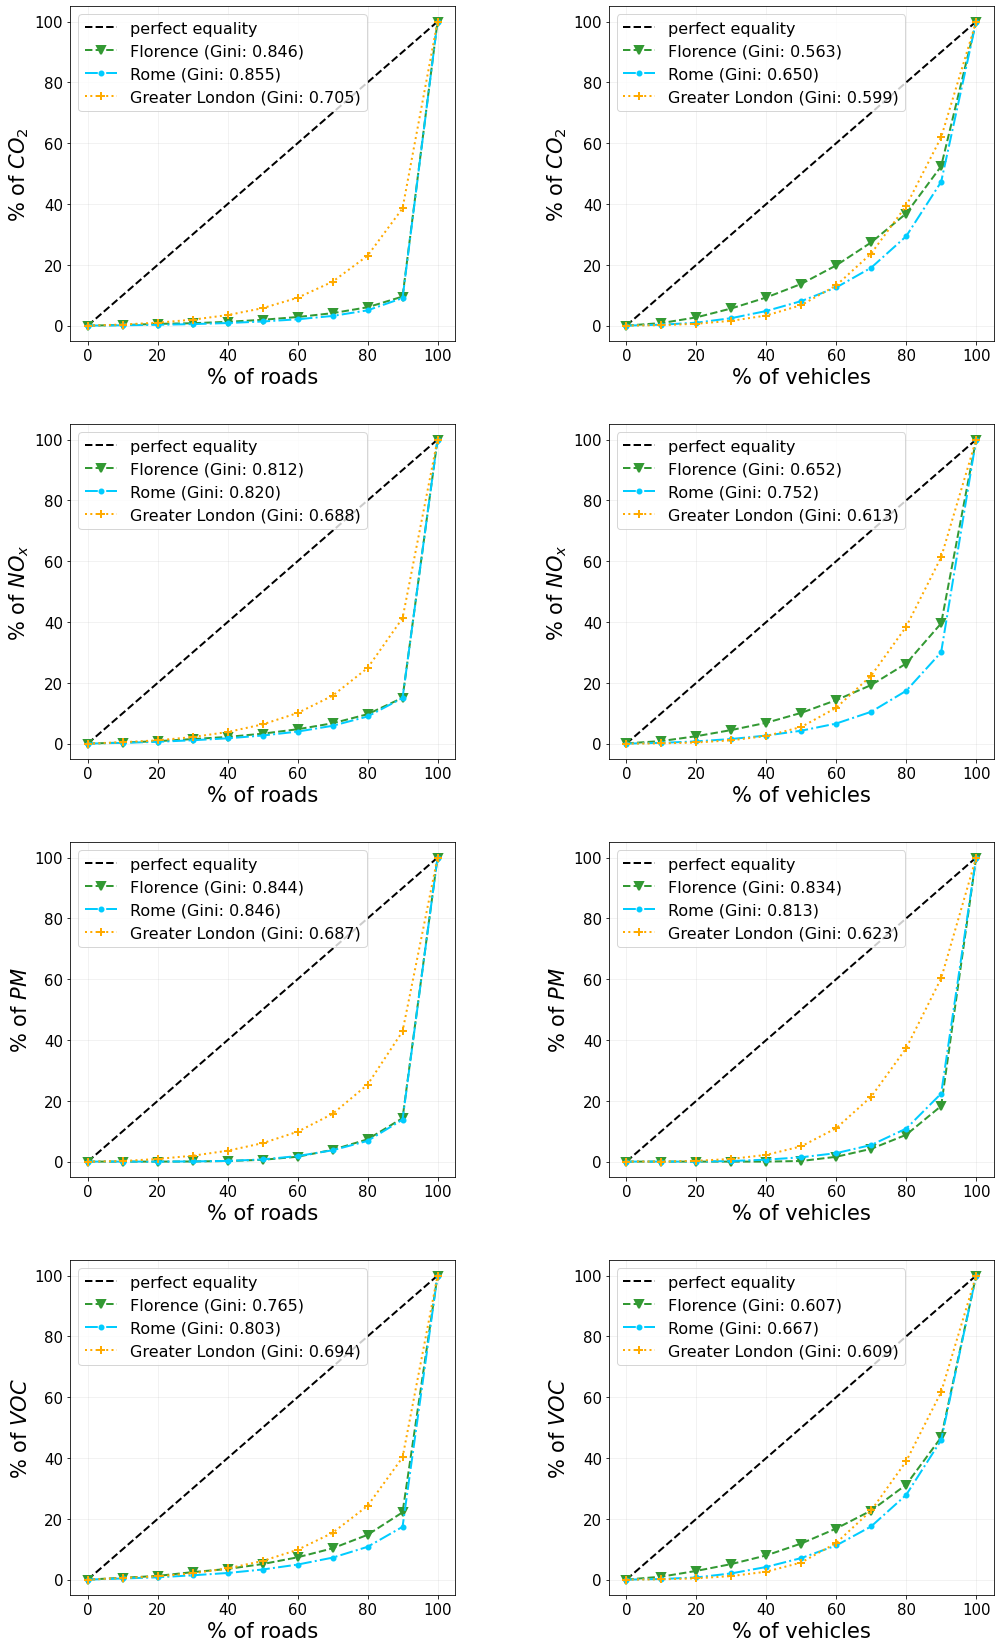

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

start_date = '2017-01-01'
end_date = '2017-01-31'


#######
list__tuple_dist_pollutant = [
    ('roads', 'CO_2'), ('vehicles', 'CO_2'),
    ('roads', 'NO_x'), ('vehicles', 'NO_x'),
    ('roads', 'PM'), ('vehicles', 'PM'),
    ('roads', 'VOC'), ('vehicles', 'VOC'),
]
map__city__plot_pars = {
    'rome' : {
        'linestyle' : '-.',
        'marker' : '.',
        'color' : '#00ccff'
    },
    'greater_london' : {
        'linestyle' : ':',
        'marker' : '+',
        'color' : '#ffaa00'
    },
    'florence' : {
        'linestyle' : '--',
        'marker' : 'v',
        'color' : '#339933'
    }
}
#######

####
# defining the function used for computing the curve and the Gini coefficient
def Lorenz(v, bins):
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return yvals, gini_val
####


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 23))

for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    # plotting line of perfect equality
    bins = np.linspace(0., 100., 11)
    ax.plot(bins, bins, '--', label="perfect equality", color='black', linewidth=2)
    
    for c_city in ['Florence', 'Rome', 'Greater London']:

        city_name = c_city.lower().replace(" ", "_")
        trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
        NAME_OF_INPUT_FILE = dict_file_names[(city_name, 
                                              start_date, end_date, 
                                              trajectory_type)]
        df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
        
        # tacking the column with the current pollutant
        list_cumulate_emissions = list(df[c_pollutant])
        
        # plotting Lorenz curve for current city
        result, gini_val = Lorenz(np.array(list_cumulate_emissions), bins)
        ax.plot(bins, result, label='%s (Gini: %.3f)' %(c_city, gini_val), 
                color=map__city__plot_pars[city_name]['color'],
                linestyle=map__city__plot_pars[city_name]['linestyle'],
                linewidth=2, alpha=1,
                marker=map__city__plot_pars[city_name]['marker'],
                markersize=8, markeredgewidth=2,
                markerfacecolor=map__city__plot_pars[city_name]['color'], markeredgecolor=map__city__plot_pars[city_name]['color'])
        
    ax.set_xlabel(r'%% of %s' %dist_type, fontsize=21)
    ax.set_ylabel(r'%% of $%s$' %c_pollutant, fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=16)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.25)
plt.show()

## Fitting of distributions
Code for obtaining the __Figures 2b,c,e,f,h,i__ and __Supplementary Figures 13-16__, and for __Supplementary Tables 3-7__.

The methods are collected in ```fitting.py```, and can are used here to fit and plot _one single_ distribution (i.e. of one type - per vehicle/road -, for one pollutant, and for one city) per run.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fitting import *

start_date = '2017-01-01'
end_date = '2017-01-31'

# define the city, pollutant and type of distribution that one wants to fit
city_name = 'Greater London'  # one of "Greater London", "Rome", "Florence"
pollutant = 'CO_2'
dist_type = 'roads'
#

############
# loading df
region_name = city_name.lower().replace(" ", "_")
trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
NAME_OF_INPUT_FILE = dict_file_names[(region_name, 
                                      start_date, end_date, 
                                      trajectory_type)]
df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)

list_cumulate_emissions = list(df[pollutant])

map__dist_type__distribution = {
    dist_type : list_cumulate_emissions,
}

map__dist_type__fitting_results, map__dist_type__comparison_results = fit_powerlaw(map__dist_type__distribution,
                                                                                   city_name,
                                                                                   pollutant, xmin=None,
                                                                                   sigma_threshold=0.05,
                                                                                   list_distributions_to_fit=[
                                                                                       'power_law', 'lognormal',
                                                                                       'exponential',
                                                                                       'truncated_power_law',
                                                                                       'stretched_exponential'],
                                                                                   plot_ccdf=True,
                                                                                   plot_pdf=False,
                                                                                   plot_xmin=True,
                                                                                   x_label=r'$%s$ (g)' %pollutant, 
                                                                                   single_fit_to_plot='truncated_power_law', 
                                                                                   save_figures=True)

-- Fitting distribution roads --
num points :  151174


/home/matteo/anaconda3/envs/mobility/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


fixed xmin:  False


Assuming nested distributions
Assuming nested distributions


Best fit(s) :  ['truncated_power_law']
-- end --


The following code is for reproducing the results of the log-likelihood ratio tests in a table (like the paper's __Tables 3-7__).

In [16]:
import pandas as pd

map__couple__results = map__dist_type__comparison_results[dist_type]

list_distrib = ['power_law', 'lognormal', 'truncated_power_law', 'stretched_exponential', 'exponential']
df_results = pd.DataFrame(index=list_distrib, columns=list_distrib)

map__distrib__name = {
    'power_law' : 'power-law', 
    'lognormal' : 'lognormal', 
    'truncated_power_law' : 'tr. power-law', 
    'stretched_exponential' : 'str. exponential', 
    'exponential' : 'exponential',
    None : 'None'
}

for couple, result in map__couple__results.items():
    if result['best_fit'] != None:
        label = map__distrib__name[result['best_fit']] + ' (R=%.2f, p=%.2f)' %(result['R'], result['p'])
    else:
        label = map__distrib__name[result['best_fit']]

    if (couple[0] == 'exponential') and ((couple[1] == 'truncated_power_law') or (couple[1] == 'stretched_exponential')):
        if result['best_fit'] != None:
            label = map__distrib__name[result['best_fit']] + ' (R=%.2f, p=%.2f)' %(-result['R'], result['p'])
        else:
            label = map__distrib__name[result['best_fit']]
        df_results.loc[couple[1], couple[0]] = label
    else:
        df_results.loc[couple[0], couple[1]] = label
    
df_results.index = [map__distrib__name[distrib] for distrib in df_results.index]
df_results.columns = [map__distrib__name[distrib] for distrib in df_results.columns]
df_results.fillna('-')

,power-law,lognormal,tr. power-law,str. exponential,exponential
power-law,-,None,"tr. power-law (R=-2.22, p=0.02)","power-law (R=2.13, p=0.03)","power-law (R=12.83, p=0.00)"
lognormal,-,-,"tr. power-law (R=-3.36, p=0.00)","lognormal (R=2.54, p=0.01)","lognormal (R=12.96, p=0.00)"
tr. power-law,-,-,-,"tr. power-law (R=3.78, p=0.00)","tr. power-law (R=13.14, p=0.00)"
str. exponential,-,-,-,-,"str. exponential (R=13.65, p=0.00)"
exponential,-,-,-,-,-


# Gini coefficient across different sample sizes
Code for running the experiment on sample size and thus obtaining the __Supplementary Figures 17-18__.

In [13]:
from collections import defaultdict

def run_experiment_gini(r, k, start_date, end_date, dict_file_names, dict_results):
    
    list__tuple_dist_pollutant = [
        ('roads', 'CO_2'), ('vehicles', 'CO_2'),
        ('roads', 'NO_x'), ('vehicles', 'NO_x'),
        ('roads', 'PM'), ('vehicles', 'PM'),
        ('roads', 'VOC'), ('vehicles', 'VOC'),
    ]
    map__city__color = {'Florence' : 'red',
                        'Rome' : 'orange',
                        'Greater London' : 'magenta'}
    
    ####
    # defining the function used for computing the curve and the Gini coefficient
    def Lorenz(v, bins):
        total = float(np.sum(v))
        yvals = []
        for b in bins:
            bin_vals = v[v <= np.percentile(v, b)]
            bin_fraction = (np.sum(bin_vals) / total) * 100.0
            yvals.append(bin_fraction)
        # perfect equality area
        pe_area = np.trapz(bins, x=bins)
        # lorenz area
        lorenz_area = np.trapz(yvals, x=bins)
        gini_val = (pe_area - lorenz_area) / float(pe_area)
        return yvals, gini_val
    ####
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 22))

    for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):

        # plotting line of perfect equality
        bins = np.linspace(0., 100., 11)
        ax.plot(bins, bins, '--', label="perfect equality", color='green', linewidth=2)

        for city_name in map__city__color.keys():
            # loading df
            region_name = city_name.lower().replace(" ", "_")
            trajectory_type = 'emissions_traj_aggregated_by_' + dist_type[:-1]
            NAME_OF_INPUT_FILE = dict_file_names[(region_name, 
                                                  start_date, end_date, 
                                                  trajectory_type)]
            df_all = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
            # SAMPLING
            df = df_all.sample(frac=r/100, 
                               #random_state=k, 
                               axis=0)
            
            # tacking the column with the current pollutant
            list_cumulate_emissions = list(df[c_pollutant])

            # computing Gini and plotting Lorenz curve for current city & pollutant
            result, gini_val = Lorenz(np.array(list_cumulate_emissions), bins)
            
            if dict_results.default_factory == list:
                dict_results[(city_name, c_pollutant, dist_type[:-1])].append(gini_val)
            else:
                print('dict_results must be created as a collections.defaultdict(list).')
                break
            
            ax.plot(bins, result, label='%s (Gini: %.3f)' %(city_name, gini_val), color=map__city__color[city_name], linewidth=2)
        
        ax.set_xlabel(r'%% of %s' %dist_type, fontsize=21)
        ax.set_ylabel(r'%% of $%s$' %c_pollutant, fontsize=21)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.grid(alpha=0.2)
        ax.legend(fontsize=16)
        
    plt.subplots_adjust(wspace = 5, hspace = 4)
    plt.tight_layout()
    #plt.show()
    plt.close()
    
    return dict_results, fig, ax

For each $k$ sample composed by the $r$\% of the vehicles we compute and collect the Gini coefficient of the resulting emissions' distribution across the vehicles and roads in the three cities.

In [14]:
## note: this takes a few minutes

k_list = [1,2,3,4,5,6,7,8,9,10]
r_list = [10,20,30,40,50,60,70,80,90,100]

map__r_value__results = {}

for r in r_list:
    map__city_pollutant_dist__gini = defaultdict(list) # in this way I can easily append the result of each experiment to the list mapped to each key
    for k in k_list:
        print('Sample n° %s of %s%% of the data.' %(k,r))
        map__city_pollutant_dist__gini, fig, ax = run_experiment_gini(r, k, start_date, end_date, dict_file_names, map__city_pollutant_dist__gini)
        
    map__r_value__results[r] = map__city_pollutant_dist__gini

Sample n° 1 of 10% of the data.
Sample n° 2 of 10% of the data.
Sample n° 3 of 10% of the data.
Sample n° 4 of 10% of the data.
Sample n° 5 of 10% of the data.
Sample n° 6 of 10% of the data.
Sample n° 7 of 10% of the data.
Sample n° 8 of 10% of the data.
Sample n° 9 of 10% of the data.
Sample n° 10 of 10% of the data.
Sample n° 1 of 20% of the data.
Sample n° 2 of 20% of the data.
Sample n° 3 of 20% of the data.
Sample n° 4 of 20% of the data.
Sample n° 5 of 20% of the data.
Sample n° 6 of 20% of the data.
Sample n° 7 of 20% of the data.
Sample n° 8 of 20% of the data.
Sample n° 9 of 20% of the data.
Sample n° 10 of 20% of the data.
Sample n° 1 of 30% of the data.
Sample n° 2 of 30% of the data.
Sample n° 3 of 30% of the data.
Sample n° 4 of 30% of the data.
Sample n° 5 of 30% of the data.
Sample n° 6 of 30% of the data.
Sample n° 7 of 30% of the data.
Sample n° 8 of 30% of the data.
Sample n° 9 of 30% of the data.
Sample n° 10 of 30% of the data.
Sample n° 1 of 40% of the data.
Sampl

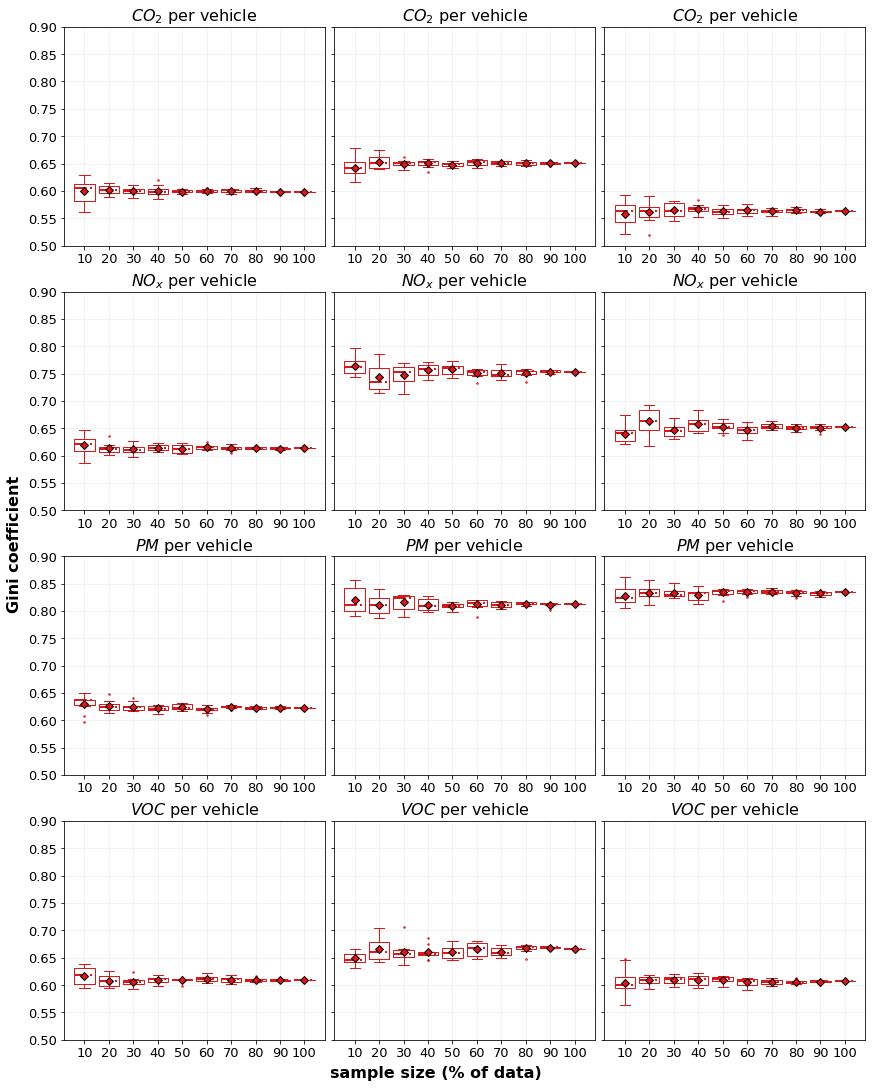

In [15]:
metric_name = 'Gini'

show_outliers=True
show_means=True

# choose the type of distribution of emissions: per vehicle / per road 
dist_type = 'vehicle'  # one of {'vehicle', 'road'}


####
list__tuple_city_pollutant = [
    ('Greater London', 'CO_2'), ('Rome', 'CO_2'), ('Florence', 'CO_2'), 
    ('Greater London', 'NO_x'), ('Rome', 'NO_x'), ('Florence', 'NO_x'), 
    ('Greater London', 'PM'), ('Rome', 'PM'), ('Florence', 'PM'), 
    ('Greater London', 'VOC'), ('Rome', 'VOC'), ('Florence', 'VOC'), 
]
####

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15), constrained_layout=True, sharex=False, sharey=True)

for ax, (city_name, c_pollutant) in zip(axs.flat, list__tuple_city_pollutant):

    map__r_value__one_result = {r : result[(city_name,c_pollutant,dist_type)] for r,result in map__r_value__results.items()}
    
    data = [distrib for x_key,distrib in sorted(map__r_value__one_result.items())]
    list_of_x_keys = sorted(map__r_value__one_result.keys())

    #
    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
        plt.setp(bp['fliers'], markeredgecolor=color)
        return

    epsilon_widths = 0.1
    selected_width = 0.5
    pos_a = []
    c_position = 0
    for index in range(len(list_of_x_keys)):
        pos_a.append(c_position)
        c_position += selected_width + epsilon_widths

    bpl = ax.boxplot(data, positions=pos_a, widths=selected_width,
                    showfliers=show_outliers,
                    showmeans=show_means,
                    flierprops=dict(marker='o', markersize=3 * selected_width, markeredgewidth=0.99),
                    medianprops = dict(linestyle='-.', linewidth=2),
                    meanprops = dict(marker='D', markersize=5, markeredgecolor='black', markerfacecolor='#D7191C', markeredgewidth=0.99))
    set_box_color(bpl, '#D7191C')

    ax.set_xticks(pos_a)  ##########
    ax.set_xticklabels(list_of_x_keys)
    
    #ax.set_ylim(0.65, 0.90)
    ax.set_ylim(0.50, 0.90)
    #ax.set_xlabel("sample size (% of data)", size='large', weight='bold' , fontsize=16)
    #ax.set_ylabel(metric_name.replace('_', ' '), size='large', weight='bold' , fontsize=16)
    
    #ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=13)
    #ax.set_title(r'$%s$ per %s, %s' %(c_pollutant, dist_type, city_name.replace('_',' ').capitalize()), fontsize=16)
    ax.set_title(r'$%s$ per %s' %(c_pollutant, dist_type), fontsize=16)
    ax.grid(alpha=0.2)

fig.supxlabel("sample size (% of data)", size='large', weight='bold' , fontsize=16)
fig.supylabel("Gini coefficient", size='large', weight='bold' , fontsize=16, ha='left')

#plt.tight_layout()
plt.show()

# Filtering parameter $\theta$
Code for obtaining the __Supplementary Figures 19-21__.

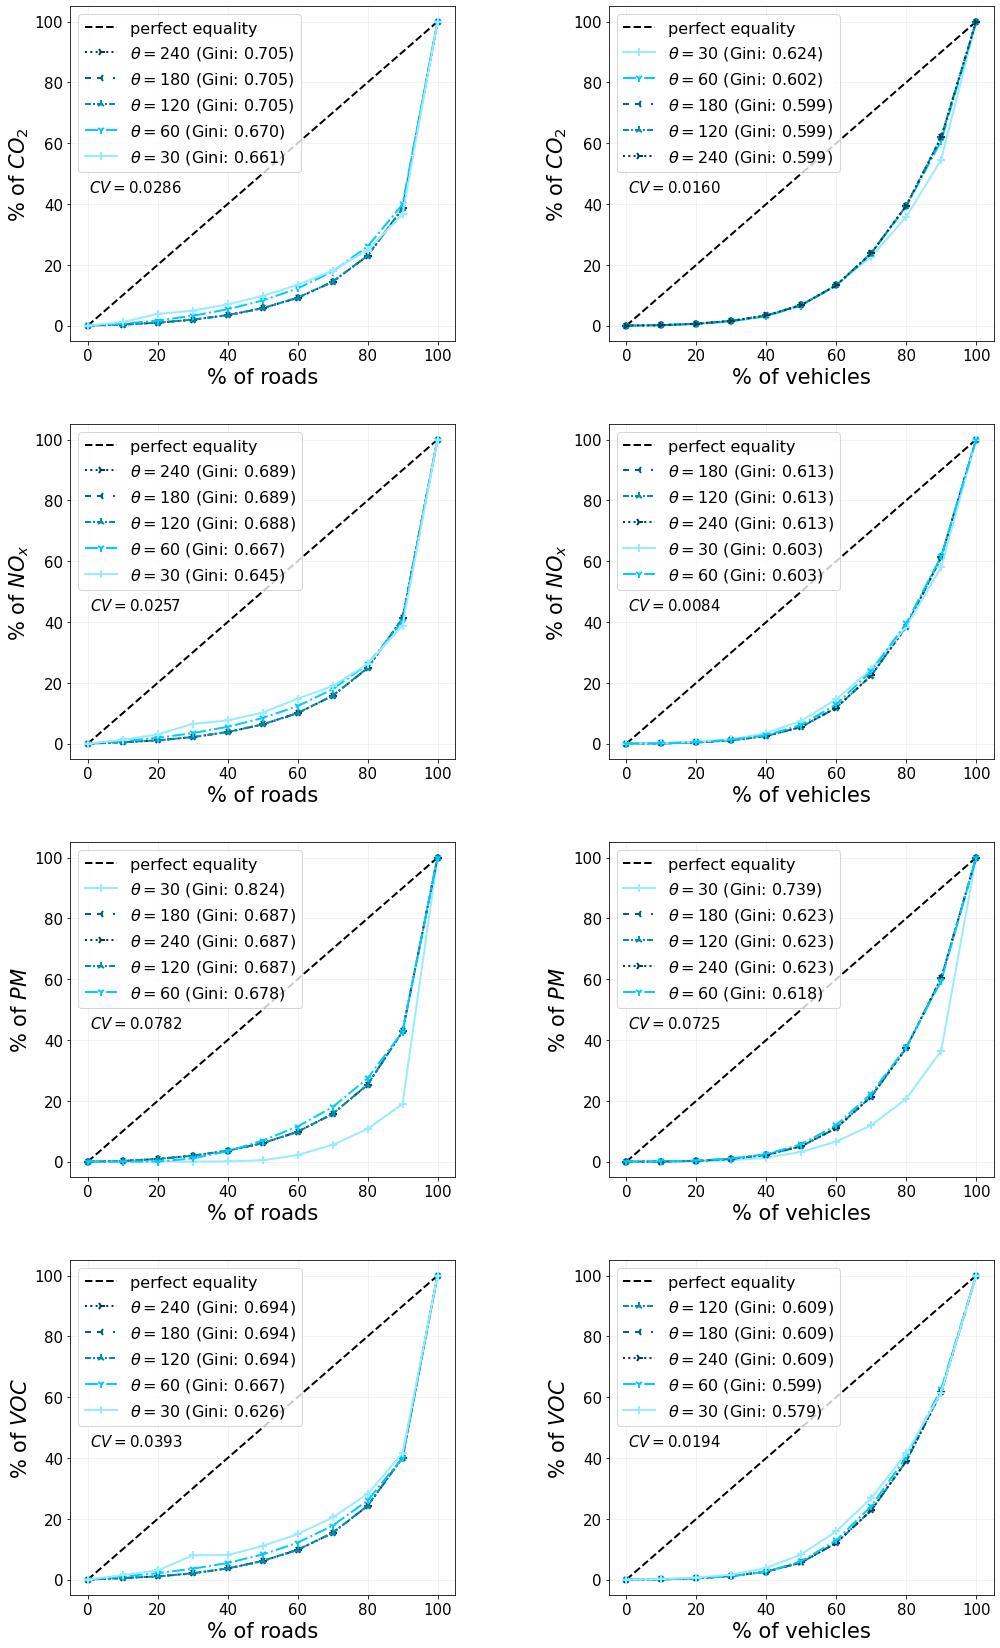

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import variation

# choose on of "Greater London", "Rome", "Florence"
REGION = 'Greater London'


## Note: there is a different dict_file_names for these data input files
PATH_TO_INPUT_FILES__theta = './data/private/lambda_par/'
infile = open(PATH_TO_INPUT_FILES__theta + 'input_file_names__exp_time_filtering.pkl','rb')
dict_file_names__theta = pickle.load(infile)


list_thetas = ['30', '60', '120', '180', '240']

list__tuple_dist_pollutant = [
    ('roads', 'CO_2'), ('vehicles', 'CO_2'),
    ('roads', 'NO_x'), ('vehicles', 'NO_x'),
    ('roads', 'PM'), ('vehicles', 'PM'),
    ('roads', 'VOC'), ('vehicles', 'VOC'),
]
map__theta__plot_pars = {
    '30' : {
        'linestyle' : '-',
        'marker' : '+',
        'color' : '#99ebff'
    },
    '60' : {
        'linestyle' : '-.',
        'marker' : '1',
        'color' : '#00ccff'
    },
    '120' : {
        'linestyle' : (0, (3, 1, 1, 1)), #densely dashdotted
        'marker' : '2',
        'color' : '#008fb3'
    },
    '180' : {
        'linestyle' : (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
        'marker' : '3',
        'color' : '#006680'
    },
    '240' : {
        'linestyle' : ':',
        'marker' : '4',
        'color' :  '#003d4d'
    }
}

####
# defining the function used for computing the curve and the Gini coefficient
def Lorenz(v, bins):
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return yvals, gini_val
####


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 23))

for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    # plotting line of perfect equality
    bins = np.linspace(0., 100., 11)
    ax.plot(bins, bins, '--', label="perfect equality", color='black', linewidth=2)
    
    map__lambda__gini = {}
    map__lambda__result = {}
    for c_lambda in list_thetas:
        # loading df
        region_name = REGION.lower().replace(" ", "_")
        start_date = '2017-01-01'
        end_date = '2017-01-31'
        trajectory_type = 'emissions_traj_aggregated_by_%s__filtering_par_%s' %(dist_type[:-1], c_lambda)
        NAME_OF_INPUT_FILE = dict_file_names__theta[(region_name, 
                                                      start_date, end_date, 
                                                      trajectory_type)]
        df = pd.read_csv(PATH_TO_INPUT_FILES__theta + NAME_OF_INPUT_FILE, index_col=False)
        
        # tacking the column with the current pollutant
        list_cumulate_emissions = list(df[c_pollutant])
        
        # plotting Lorenz curve for current season
        result, gini_val = Lorenz(np.array(list_cumulate_emissions), bins)
        map__lambda__gini[c_lambda] = gini_val
        map__lambda__result[c_lambda] = result
    
    map__lambda__gini__sorted = {lam:gini for lam,gini in sorted(map__lambda__gini.items(), key=lambda item: item[1], reverse=True)}
    for c_lambda,c_gini in map__lambda__gini__sorted.items():
        ax.plot(bins, map__lambda__result[c_lambda], label=r'$\theta=%s$ (Gini: %.3f)' %(c_lambda, c_gini), 
               color=map__theta__plot_pars[c_lambda]['color'],
                linestyle=map__theta__plot_pars[c_lambda]['linestyle'],
                linewidth=2, alpha=1,
                marker=map__theta__plot_pars[c_lambda]['marker'],
                markersize=8, markeredgewidth=2,
                markerfacecolor=map__theta__plot_pars[c_lambda]['color'], markeredgecolor=map__theta__plot_pars[c_lambda]['color'])
    # coefficient of variation
    cv = variation(list(map__lambda__gini__sorted.values()))
    ax.text(0.17, 0.46, r'$CV = %.4f$' %cv, fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel(r'%% of %s' %dist_type, fontsize=21)
    ax.set_ylabel(r'%% of $%s$' %c_pollutant, fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=16)
    #handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    #ax.legend(handles, labels)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.25)
plt.show()

# Vehicles mobility
Code for obtaining the __Supplementary Figures 22-24__.

In [12]:
import glob
import pandas as pd

# choose on of "Greater London", "Rome", "Florence"
REGION = 'Greater London'

## Note: there is a different path for these data input files
PATH_TO_INPUT_FILES__vehicles = './data/private/vehicles_mobility/'
df = pd.read_csv(glob.glob(PATH_TO_INPUT_FILES__vehicles+'*%s*.csv' %REGION.lower().replace(' ', '_'))[0])

In [13]:
from scipy.stats import spearmanr

corr_coef = 'spearman' # one of "spearman" or "pearson"


list_of_pollutants = ['CO_2', 'NO_x', 'PM', 'VOC']
corr_coefs = pd.DataFrame(columns=list_of_pollutants, index=['r_gyr', 'un_entropy', 'travel_time'])
df_pvals = corr_coefs.copy()
for c_pollutant in list_of_pollutants:
    if corr_coef == 'spearman':
        spearman_radius = spearmanr(df[c_pollutant], df['r_gyr'])
        spearman_entropy = spearmanr(df[c_pollutant], df['un_entropy'])
        spearman_tt = spearmanr(df[df['travel_time'].isnull() == False][c_pollutant], df[df['travel_time'].isnull() == False]['travel_time'])


        corr_coefs.loc['r_gyr', c_pollutant] = spearman_radius[0]
        corr_coefs.loc['un_entropy', c_pollutant] = spearman_entropy[0]
        corr_coefs.loc['travel_time', c_pollutant] = spearman_tt[0]

        # p-values
        df_pvals.loc['r_gyr', c_pollutant] = spearman_radius[1]
        df_pvals.loc['un_entropy', c_pollutant] = spearman_entropy[1]
        df_pvals.loc['travel_time', c_pollutant] = spearman_tt[1]

    else:
        corr_coefs.loc['r_gyr', c_pollutant] = np.corrcoef(df[c_pollutant], df['r_gyr'])[1][0]
        corr_coefs.loc['un_entropy', c_pollutant] = np.corrcoef(df[c_pollutant], df['un_entropy'])[1][0]
        corr_coefs.loc['travel_time', c_pollutant] = np.corrcoef(df[c_pollutant], df['travel_time'])[1][0]
            

print("%s's correlation coeffs:" %corr_coef.capitalize())
print()
print(corr_coefs)

Spearman's correlation coeffs:

                 CO_2      NO_x        PM       VOC
r_gyr         0.08832  0.020492   0.01809  0.025835
un_entropy  -0.727236 -0.756912 -0.739946  -0.75869
travel_time  0.981901     0.983  0.972861  0.985733


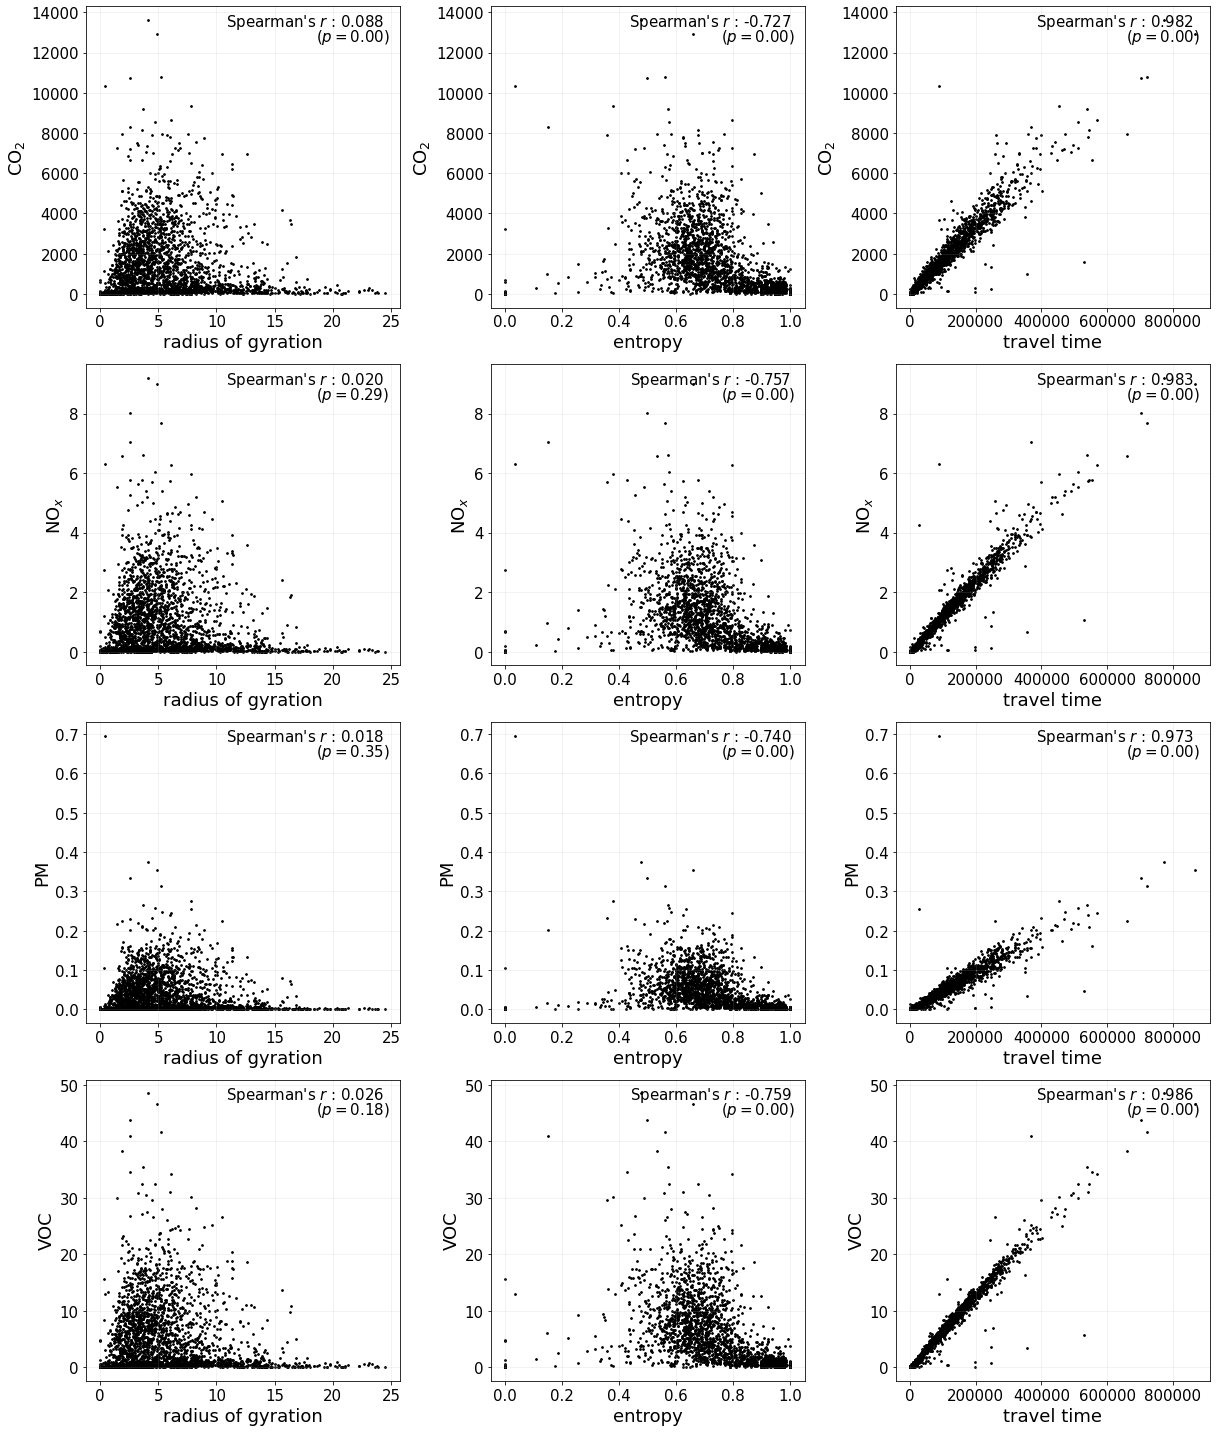

In [14]:
import matplotlib.pyplot as plt


list__tuple_feat_pollutant = [
    ('r_gyr', 'CO_2'), ('un_entropy', 'CO_2'), ('travel_time', 'CO_2'), 
    ('r_gyr', 'NO_x'), ('un_entropy', 'NO_x'), ('travel_time', 'NO_x'), 
    ('r_gyr', 'PM'), ('un_entropy', 'PM'), ('travel_time', 'PM'), 
    ('r_gyr', 'VOC'), ('un_entropy', 'VOC'), ('travel_time', 'VOC'), 
]

map__attribute__attr_label = {
    'CO_2' : r'CO$_2$', 'NO_x' : r'NO$_x$', 'PM' : 'PM', 'VOC' : 'VOC', 
    'r_gyr' : 'radius of gyration', 'un_entropy' : 'entropy', 
    'travel_time' : 'travel time'
}


fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(17, 20))

for ax, (c_feat, c_pollutant) in zip(axs.flat, list__tuple_feat_pollutant):
    
    # tacking the column with the current pollutant
    list_cumulate_emissions = list(df[c_pollutant])
    list_c_feature = list(df[c_feat])

    # plotting
    ax.scatter(list_c_feature, list_cumulate_emissions, color='black', s=3)
    ax.set_xlabel(map__attribute__attr_label[c_feat], fontsize=18)
    ax.set_ylabel(map__attribute__attr_label[c_pollutant], fontsize=18)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.text(0.70,0.95, r"Spearman's $r$ : %.3f" %corr_coefs.loc[c_feat,c_pollutant], fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.85,0.9, r"($p=%.2f$)" %df_pvals.loc[c_feat,c_pollutant], fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Simulation scenarios
Code for obtaining the __Figures 3e,f__ and __Supplementary Figures 32-33__.

### Electrification scenario

In [38]:
import random
import numpy as np
import pandas as pd

# define the city and pollutant for which one wants the simulation
city_name = 'Rome'  #one of {'Florence', 'Rome', 'Greater London', 'Municipio Roma II'}
pollutant = 'CO_2'

# loading df
df = pd.read_csv('./data/old/cumulate_emissions_per_vehicle__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
# creating a dictionary that maps each vehicle to its total emissions
map__vehicle__tot_emissions = dict(zip(df['uid'], df[pollutant]))

# creating a dictionary that maps each choice ('most polluting' or 'random') to the % reduction of the emissions 
# obtained by electrifying 0 to 99% (1%-step) of the vehicles chosen in decreasing order starting from the 'most polluting' or chosen at 'random'
map__vehicle_choice__x_percent_reduction_perc = {}
for c_choice in ['most polluting', 'random']:
    
    sum_tot_emissions = sum(map__vehicle__tot_emissions.values())
    num_vehicles = len(map__vehicle__tot_emissions.keys())
    
    map__x_percent__emissions_reduction_perc = {0 : 0}
    map__x_percent__tot_emissions_distribution = {0 : list(map__vehicle__tot_emissions.values())}
    
    for x_percent in np.arange(1,100,step=1):
        
        num_vehicles_x_percent = int(num_vehicles / 100 * x_percent)
        
        if c_choice == 'most polluting':
            map__x_percent_vehicles__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True)[0:num_vehicles_x_percent]}
        else:
            random.seed(4)  # this is the seed used for the paper's experiments
            set_random_vehicles = set(random.sample(map__vehicle__tot_emissions.keys(), num_vehicles_x_percent))
            map__x_percent_vehicles__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in set_random_vehicles}
        
        ## percent emissions reduction
        sum_x_percent_tot_emissions = sum(map__x_percent_vehicles__tot_emissions.values())
        emissions_reduction_perc = sum_x_percent_tot_emissions / sum_tot_emissions * 100
        map__x_percent__emissions_reduction_perc[x_percent] = emissions_reduction_perc
        
        map__vehicle_choice__x_percent_reduction_perc[c_choice] = map__x_percent__emissions_reduction_perc

/tmp/ipykernel_11633/1606261173.py:33: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  set_random_vehicles = set(random.sample(map__vehicle__tot_emissions.keys(), num_vehicles_x_percent))


In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
from itertools import product

### defining the Generalised Logistic Function (Richard's curve)
import numpy as np
def richard(time, alpha, beta, rate, slope):
    """
    Computes the Richard growth model
    Parameters
    ----------
    time : time
    alpha : upper asymptote
    beta : growth range
    rate : growth rate
    slope : slope of growth

    References
    ----------
    .. [1] F. J. Richards, "A flexible growth function for empirical use", Journal of Experimental Botany, 
        vol. 10, no. 29, pp. 290–300, 1959.
    .. [2] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
            of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
            4, pp. 327-336, 1999.
    """

    y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
    y = alpha / y
    
    return y
###

### defining a method to plot the emissions reduction curves together with the Richard's curve fit
def line_plotter_with_fit(map__feature__x_y, x_label, y_label, map__feature__plot_feature__value, region_name, plot_zoom=True, save_fig=False):
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)
    
    # inset axes...
    if plot_zoom:
        axins = ax.inset_axes([0.68, 0.07, 0.6, 0.6])

    for c_feature in map__feature__x_y:
        
        data = [y for x,y in sorted(map__feature__x_y[c_feature].items())]
        x = np.array([x for x,y in sorted(map__feature__x_y[c_feature].items())])
    
        if any(isinstance(el, list) for el in data):  # if the elements of data are lists (i.e. if, for each x, the element is not a single value but a distribution...)
            y = np.array([np.median(distrib) for distrib in data])
            first_quartiles = np.array([np.quantile(distrib, 0.25) for distrib in data])
            third_quartiles = np.array([np.quantile(distrib, 0.75) for distrib in data])
        else:
            y = np.array(data)


        ax.plot(x, y, 
                color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                linewidth=3, alpha=1,
                label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
               )
        if plot_zoom:
            axins.plot(x, y, 
                      color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                      linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                      linewidth=3, alpha=1,
                      label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
                    )
        
        if c_feature == 'most polluting':
            ## fitting a generalised logistic function to the "decreasing order" curve
            
            # starting guesses for the parameters (following [2] Fekedulegn et al. 1999):
            # the initial guess for the first parameter, alpha_0, is the upper asymptote to the growth, 
            # that, in our context, is equal to 100 (%).

            ## grid-search for the best initial guesses of the parameters (those that give the best r2)
            par_vec = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
            pars_grid = list(product(par_vec, repeat=2))
            
            best_r2 = 0
            best_pars = [100, pars_grid[0][0], 1/100, pars_grid[0][1]]
            for i in range(0,len(pars_grid)):
                pars_0 = [100, pars_grid[i][0], 1/100, pars_grid[i][1]]
                r2, pars, pcov, y_pred = fit_and_score(x, y, pars_0)
                if r2 > best_r2:
                    best_pars = pars_0
                    best_r2 = r2
            
            r2, pars, pcov, y_pred = fit_and_score(x, y, best_pars)
            print('Est. paramenters: ', pars)
            print('R2: ', r2)
            label_pars = r'$\alpha=%.2f$, $\beta=%.2f$,' %(pars[0], pars[1]) +'\n'+ r'$r=%.2f$, $\nu=%.2f$' %(pars[2], pars[3])
            #ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit \n'+label_pars) ## label with est. parameters
            ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')  ## label without est. parameters
            if plot_zoom:
                axins.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')
    
    ''' zoom
    x1, x2, y1, y2 = 0, 10, 0, 55
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    x_ticks = np.arange(0,11,step=1)
    plt.xticks(x_ticks, rotation=0, fontsize=16)  ##########
    plt.yticks(fontsize=16)
    '''
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    #''' no zoom
    x_ticks = np.arange(0,110,step=10)
    plt.xticks(x_ticks, rotation=0, fontsize=16)  ##########
    plt.yticks(fontsize=16)
    
    ax.set_xlabel(x_label, size='large', fontsize=18)
    ax.set_ylabel(y_label, size='large', fontsize=18)
    
    plt.legend(loc='upper left', fontsize=16, framealpha=0.6, handlelength=1.5, bbox_to_anchor=(1.02, 0))
    plt.title(region_name, fontsize=18)
    #'''
    plt.grid(alpha=0.5)

    if plot_zoom:
        x1, x2, y1, y2 = 0, 10, 0, 55
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.grid(alpha=0.5)
        axins.xaxis.set_major_locator(MaxNLocator(integer=True))
        #
        #ax.indicate_inset_zoom(axins, edgecolor='black', linestyle='--')

    if save_fig:
        plot_file_name = "plot_lines__electrification_simulation__" + pollutant + '__emissions_reduction__'+str(region_name).replace(' ','_').lower()+'__with_fit.svg'
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()
    #
    return
###
def fit_and_score(x, y, pars_0):
    try:
        pars, pcov = curve_fit(richard, x, y, p0 = pars_0, method='lm', maxfev=5000)
        #print('Est. paramenters: ', pars)
        y_pred = richard(x, pars[0], pars[1], pars[2], pars[3])
        residuals = y - y_pred
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
    except RuntimeError:
        return 0, pars_0, [], []
    
    return r2, pars, pcov, y_pred

/tmp/ipykernel_11633/864539381.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
/home/matteo/anaconda3/envs/mobility/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_11633/864539381.py:28: RuntimeWarning: invalid value encountered in power
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
/tmp/ipykernel_11633/864539381.py:28: RuntimeWarning: overflow encountered in power
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)


Est. paramenters:  [ 1.01250531e+02 -1.00000000e+00  3.96325659e-02 -1.56517866e+00]
R2:  0.9994896328279187


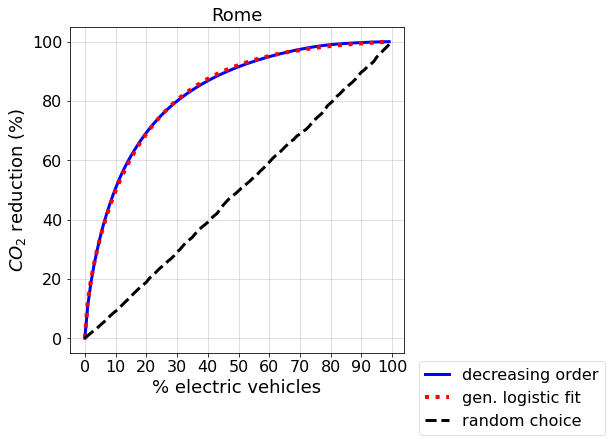

In [48]:
map__vehicle_choice__plot_feature__value = {
    'most polluting' : {'name' : 'decreasing order',
                       'color' : 'blue',
                        'lstyle' : '-'},
    'random' : {'name' : 'random choice',
               'color' : 'black',
                'lstyle' : '--'}
}

line_plotter_with_fit(map__vehicle_choice__x_percent_reduction_perc, 
                      '% electric vehicles', r'$CO_2$ reduction (%)', 
                      map__vehicle_choice__plot_feature__value, city_name, 
                      plot_zoom=False, save_fig=False)

### Home working scenario

In [4]:
import random
import numpy as np
import pandas as pd

# define the city and pollutant for which one wants the simulation
city = 'Florence'  #one of {'Florence', 'Rome', 'Greater London'}
pollutant = 'CO_2'

PATH_TO_INPUT_FILES = './data/'
OUTPUT_PATH = './output/'
city_name = city.lower().replace(" ", "_")
OUTPUT_FILENAME = 'Figure_homeworking_%s.pdf' %city_name

start_date = '2017-01-01'
end_date = '2017-12-22' # '2017-01-31'

In [7]:

# loading df
#df = pd.read_csv('./data/cumulate_emissions_per_vehicle__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
trajectory_type = 'emissions_traj_subsampled_aggregated_by_vehicle'
NAME_OF_INPUT_FILE = dict_file_names[(city_name, 
                                      start_date, end_date, 
                                      trajectory_type)]
df = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
# creating a dictionary that maps each vehicle to its total emissions
map__vehicle__tot_emissions = dict(zip(df['uid'], df[pollutant]))
sum_tot_emissions = sum(map__vehicle__tot_emissions.values())
num_vehicles = len(map__vehicle__tot_emissions.keys())


# loading df with commuting trajectories
#df_commuting = pd.read_csv('./data/cumulate_emissions_per_vehicle_from_commuting_traj__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
trajectory_type = 'emissions_commuting_traj_subsampled_aggregated_by_vehicle'
NAME_OF_INPUT_FILE = dict_file_names[(city_name, 
                                      start_date, end_date, 
                                      trajectory_type)]
df_commuting = pd.read_csv(PATH_TO_INPUT_FILES + NAME_OF_INPUT_FILE, index_col=False)
# creating a dictionary that maps each vehicle to its total emissions
map__commuters__tot_emissions = dict(zip(df_commuting['uid'], df_commuting[pollutant]))
sum_commuting_emissions = sum(map__commuters__tot_emissions.values())
set_commuters = set(map__commuters__tot_emissions.keys())
num_commuters = len(set_commuters)

# creating a dictionary that maps each choice ('most polluting' or 'random') to the % reduction of the emissions 
# obtained with the stop of commuting of the vehicles chosen in decreasing order starting from the 'most polluting' or chosen at 'random'
map__vehicle_choice__x_percent_reduction_perc = {}
for c_choice in ['most polluting', 'random']:
    
    map__x_percent__emissions_reduction_perc = {0 : 0}
    map__x_percent__tot_emissions_distribution = {0 : list(map__vehicle__tot_emissions.values())}
    
    for x_percent in np.arange(1,101,step=1):
        
        num_commuters_x_percent = int(num_commuters / 100 * x_percent)
        perc_commuters_over_total = num_commuters_x_percent / num_vehicles * 100
        
        if c_choice == 'most polluting':
            map__x_percent_gross_polluters_that_are_commuters__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in map__commuters__tot_emissions.keys()}
            map__x_percent_commuters__tot_emissions = {uid : map__commuters__tot_emissions[uid] for uid,tot_emissions in sorted(map__x_percent_gross_polluters_that_are_commuters__tot_emissions.items(), key=lambda item: item[1], reverse=True)[0:num_commuters_x_percent]}
        else:
            random.seed(4)
            set_random_commuters = set(random.sample(set_commuters, num_commuters_x_percent))
            map__x_percent_commuters__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__commuters__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in set_random_commuters}
        
        ## percent emissions reduction
        sum_x_percent_tot_emissions = sum(map__x_percent_commuters__tot_emissions.values())
        emissions_reduction_perc = sum_x_percent_tot_emissions / sum_tot_emissions * 100
        map__x_percent__emissions_reduction_perc[perc_commuters_over_total] = emissions_reduction_perc
        
        map__vehicle_choice__x_percent_reduction_perc[c_choice] = map__x_percent__emissions_reduction_perc

print('Number of commuters: %s (%.2f %% of total)' %(num_commuters, num_commuters/num_vehicles * 100))
perc_emissions_from_commuting = sum_commuting_emissions/sum_tot_emissions * 100
print('Perc of emissions coming from commuting: ', perc_emissions_from_commuting)

Number of commuters: 1897 (65.32 % of total)
Perc of emissions coming from commuting:  28.25106786380349


/tmp/ipykernel_8747/2989039241.py:45: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  set_random_commuters = set(random.sample(set_commuters, num_commuters_x_percent))


In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
from itertools import product

### defining the Generalised Logistic Function (Richard's curve)
import numpy as np
def richard(time, alpha, beta, rate, slope):
    """
    Computes the Richard growth model
    Parameters
    ----------
    time : time
    alpha : upper asymptote
    beta : growth range
    rate : growth rate
    slope : slope of growth

    References
    ----------
    .. [1] F. J. Richards, "A flexible growth function for empirical use", Journal of Experimental Botany, 
        vol. 10, no. 29, pp. 290–300, 1959.
    .. [2] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
            of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
            4, pp. 327-336, 1999.
    """

    y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
    y = alpha / y
    
    return y
###

### defining a method to plot the emissions reduction curves together with the Richard's curve fit
def line_plotter_with_fit(map__feature__x_y, perc_emissions_from_commuting, x_label, y_label, map__feature__plot_feature__value, plot_title, ax):
    
    #plt.figure(figsize=(6, 6))
    #ax = plt.subplot(1, 1, 1)

    for c_feature in map__feature__x_y:
        
        data = [y for x,y in sorted(map__feature__x_y[c_feature].items())]
        x = np.array([x for x,y in sorted(map__feature__x_y[c_feature].items())])
    
        if any(isinstance(el, list) for el in data):  # if the elements of data are lists (i.e. if, for each x, the element is not a single value but a distribution...)
            y = np.array([np.median(distrib) for distrib in data])
            first_quartiles = np.array([np.quantile(distrib, 0.25) for distrib in data])
            third_quartiles = np.array([np.quantile(distrib, 0.75) for distrib in data])
        else:
            y = np.array(data)


        ax.plot(x, y, 
                color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                linewidth=3, alpha=1,
                label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
               )
    
        if any(isinstance(el, list) for el in data):
            ax.fill_between(x, third_quartiles, first_quartiles, alpha=0.125, 
                            facecolor=map__feature__plot_feature__value[c_feature]['color'])

        if c_feature == 'most polluting':
            ## fitting a generalised logistic function to the "decreasing order" curve
            
            # starting guesses for the parameters (following [2] Fekedulegn et al. 1999):
            # the initial guess for the first parameter, alpha_0, is the upper asymptote to the growth, 
            # that, in our context, is equal to the tot % of emissions coming from commuting in that city

            ## grid-search for the best initial guesses of the parameters (those that give the best r2)
            par_vec = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
            pars_grid = list(product(par_vec, repeat=2))
            
            best_r2 = 0
            best_pars = [perc_emissions_from_commuting, pars_grid[0][0], 1/perc_emissions_from_commuting, pars_grid[0][1]]
            for i in range(0,len(pars_grid)):
                pars_0 = [perc_emissions_from_commuting, pars_grid[i][0], 1/perc_emissions_from_commuting, pars_grid[i][1]]
                r2, pars, pcov, y_pred = fit_and_score(x, y, pars_0)
                if r2 > best_r2:
                    best_pars = pars_0
                    best_r2 = r2
            
            r2, pars, pcov, y_pred = fit_and_score(x, y, best_pars)
            print('Est. paramenters: ', pars)
            print('R2: ', r2)
            label_pars = r'$\alpha=%.2f$, $\beta=%.2f$,' %(pars[0], pars[1]) +'\n'+ r'$r=%.2f$, $\nu=%.2f$' %(pars[2], pars[3])
            ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit \n'+label_pars) ## label with est. parameters
            #ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')  ## label without est. parameters

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    #plt.xticks(rotation=0, fontsize=16)  ##########
    #plt.yticks(fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    ax.set_xlabel(x_label, size='large', fontsize=18)
    ax.set_ylabel(y_label, size='large', fontsize=18)
    
    #lt.legend(loc='lower right', fontsize=16, framealpha=0.6, handlelength=1.5)
    ax.legend(loc='lower right', fontsize=16, framealpha=0.6, handlelength=1.5)
    #plt.grid(alpha=0.5)
    ax.grid(alpha=0.2)
    ax.set_title(plot_title, fontsize=18)
    #
    #
    return
###
def fit_and_score(x, y, pars_0):
    try:
        pars, pcov = curve_fit(richard, x, y, p0 = pars_0, method='lm', maxfev=5000)
        #print('Est. paramenters: ', pars)
        y_pred = richard(x, pars[0], pars[1], pars[2], pars[3])
        residuals = y - y_pred
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
    except RuntimeError:
        return 0, pars_0, [], []
    
    return r2, pars, pcov, y_pred

/tmp/ipykernel_8747/1113317550.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
/tmp/ipykernel_8747/1113317550.py:29: RuntimeWarning: divide by zero encountered in true_divide
  y = alpha / y
/home/matteo/anaconda3/envs/mobility/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_8747/1113317550.py:28: RuntimeWarning: invalid value encountered in power
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
/tmp/ipykernel_8747/1113317550.py:29: RuntimeWarning: overflow encountered in true_divide
  y = alpha / y
/tmp/ipykernel_8747/1113317550.py:28: RuntimeWarning: overflow encountered in power
  y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)


Est. paramenters:  [28.50567693 -0.99999998  0.05730407 -1.73272174]
R2:  0.9989068734413533


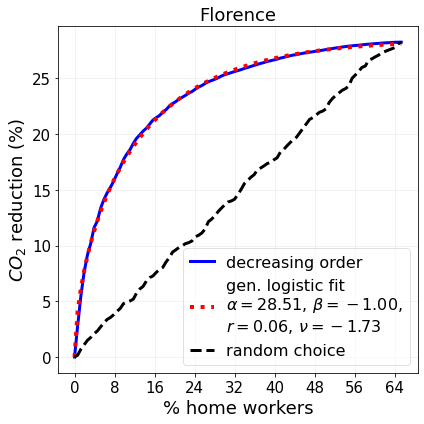

In [33]:
map__vehicle_choice__plot_feature__value = {
    'most polluting' : {'name' : 'decreasing order',
                       'color' : 'blue',
                        'lstyle' : '-'},
    'random' : {'name' : 'random choice',
               'color' : 'black',
                'lstyle' : '--'}
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

plot_title = city
line_plotter_with_fit(map__vehicle_choice__x_percent_reduction_perc, perc_emissions_from_commuting,
                          '% home workers', r'$CO_2$ reduction (%)', 
                          map__vehicle_choice__plot_feature__value, plot_title, ax)
#line_plotter_with_fit(map__feature__x_y, perc_emissions_from_commuting, x_label, y_label, map__feature__plot_feature__value, plot_title, ax, save_fig=False)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, hspace = 0.25)
plt.show()